In [1]:
import pandas as pd
import random
from time import sleep
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
import numpy as np
import nltk
import os
from sklearn import datasets
import pickle
from nltk.tokenize import word_tokenize
from sklearn.decomposition import NMF, TruncatedSVD
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.neighbors import NearestNeighbors
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, roc_curve, auc, fbeta_score
from sklearn.model_selection import learning_curve, KFold, GridSearchCV, cross_val_score
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.dummy import DummyClassifier
from collections import Counter
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import text
from sklearn.preprocessing import normalize
import re
from unidecode import unidecode

import matplotlib.style as style
%matplotlib inline
plt.style.use('ggplot')

/Users/brendenrossin/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
with open('data/cleaned_df.pkl', 'rb') as picklefile:
    df = pickle.load(picklefile)

In [3]:
df.head()

,song_owner,song_title,song_element,verse,artist
0,Childish Gambino,This Is America,[Bridge: Childish Gambino & Young Thug],"We just wanna party, Party just for you, We ju...",Childish Gambino
1,Childish Gambino,This Is America,[Chorus: Childish Gambino],"This is America, Don't catch you slippin' now,...",Childish Gambino
2,Childish Gambino,This Is America,"[Verse 1: Childish Gambino, Blocboy JB, Slim J...","This is America (skrrt, skrrt, woo), Don't cat...",Childish Gambino
3,Childish Gambino,This Is America,[Refrain: Choir & Childish Gambino],"Ooh-ooh-ooh-ooh-ooh, tell somebody, You go tel...",Childish Gambino
4,Childish Gambino,This Is America,"[Chorus: Childish Gambino, Slim Jxmmi & Young ...","This is America (woo, ayy), Don't catch you sl...",Childish Gambino


In [4]:
model_df = df.copy()

model_df = model_df[model_df['artist'] == 'Kendrick Lamar']

In [5]:
model_df['verse_words'] = model_df['verse'].copy()
model_df['verse_words'] = model_df['verse_words'].str.lower()
model_df['verse_words'] = model_df['verse_words'].apply(lambda x: x.replace(',',''))
model_df['verse_words'] = model_df['verse_words'].apply(lambda x: x.split(' '))

In [6]:
model_df.head()

,song_owner,song_title,song_element,verse,artist,verse_words
1283,Drake,Buried Alive (Interlude),[Verse 1: Kendrick Lamar],"Lookin' in the mirror, I'm embarrassed, I'm fe...",Kendrick Lamar,"[lookin', in, the, mirror, i'm, embarrassed, i..."
1806,Drake,Buried Alive (Interlude),[Verse 1: Kendrick Lamar],"Lookin' in the mirror, I'm embarrassed, I'm fe...",Kendrick Lamar,"[lookin', in, the, mirror, i'm, embarrassed, i..."
2890,Kendrick Lamar,Look Out For Detox,[Intro],"Uh, shoutout to ScHoolboy Q, He uglier than a ...",Kendrick Lamar,"[uh, shoutout, to, schoolboy, q, he, uglier, t..."
2891,Kendrick Lamar,Look Out For Detox,[Verse],"Tire marks, tire marks, Finish line with the t...",Kendrick Lamar,"[tire, marks, tire, marks, finish, line, with,..."
2892,Kendrick Lamar,HUMBLE.,[Intro],"Nobody pray for me, It's been that day for me,...",Kendrick Lamar,"[nobody, pray, for, me, it's, been, that, day,..."


In [7]:
from nltk.tokenize import word_tokenize
model_df['tokenize_verse'] = model_df['verse'].copy()
model_df['tokenize_verse'] = model_df['tokenize_verse'].str.lower()
model_df['tokenize_verse'] = model_df['tokenize_verse'].apply(lambda x: word_tokenize(x))

In [8]:
model_df['verse'] = model_df['verse'].str.lower()
model_df['verse'] = model_df['verse'].apply(lambda x: x.replace("'",''))
model_df['verse'] = model_df['verse'].apply(lambda x: "".join([c if c.isalnum() else " " for c in x ]))
model_df['verse'] = model_df['verse'].apply(lambda x: x.replace('  ',' '))

In [9]:
stopwords = ["yeah", "uh", "huh", "aw", "oh", "la", "ayy",
            "na", "ha", "ay", "skrrt",
            "em", "bla", "woo", "wu", "ya", "wala", "woop", "wrarrr", "ooh",
            "ba", "duh", "du", "1", "2", "3", "4" ,"5" ,"6", "7", "8", "9", "0"]

for index, row in model_df.iterrows():
    querywords = row['verse'].split()

    resultwords  = [word for word in querywords if word.lower() not in stopwords]
    row['verse'] = ' '.join(resultwords)

model_df.verse[:5]

1283    lookin in the mirror im embarrassed im feelin ...
1806    lookin in the mirror im embarrassed im feelin ...
2890    shoutout to schoolboy q he uglier than a mothe...
2891    tire marks tire marks finish line with the tir...
2892    nobody pray for me its been that day for me wa...
Name: verse, dtype: object

In [10]:
verses = list(model_df.verse.values)

In [11]:
verses[:10]

['lookin in the mirror im embarrassed im feelin like a suicidal terrorist react like an infant whenever you are mentioned mind over matter never worked for my nemesis im in the matter of man arm wrestlin hands i was dealt when i said the music business was all i needed when i got it i was greeted by an alien that said last year that she slept with a canadian that gave him an addiction thatd keep him in mercedes benz bright lights and rihanna as a lady friend my vice is similar women love when youre my type and youre winnin from everything that your palm write put her in the palms hotel sin city devil in a dress platinum chanel live the ambiance all cause the audience one day said i would do it so instead of a verse bein read ima go and get some head off the strength of my music i tell a bad bitch yo ass too fat capitalize that and your weave look good with the indian tracks trackin device on your used series i dont call back just blame it on your canadian the same day we say were in th

In [12]:
all_verses_all_rappers = ','.join(verses)

all_verses_all_rappers[:100]

'lookin in the mirror im embarrassed im feelin like a suicidal terrorist react like an infant wheneve'

In [13]:
file = all_verses_all_rappers

In [14]:
# Read in text and change unicode characters to ASCII
import unidecode
import string
import random
import re

all_characters = string.printable
n_characters = len(all_characters)

file_len = len(file)
print(f'file_len = {file_len}')

file_len = 712344


In [15]:
chunk_len = 400

def random_chunk():
    start_index = random.randint(0, file_len - chunk_len)
    end_index = start_index + chunk_len + 1
    return file[start_index:end_index]

print(random_chunk())

w im like i fuckin hate it bad and so we holler fuck what you heard see we been down for too long fuck what you heard we been tired of doin wrong if you got the nerve to man up and kill a man then man up double time and shake that adversarys hand bang,ah this for the hatred in you this is for that place of darkness they have placed into you this is for the early coffins of those discriminated or ra


In [16]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)
        
    def forward(self, input, hidden):
        output = self.encoder(input.view(1, -1))
        output, hidden = self.gru(output.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        
        return output, hidden
    
    def init_hidden(self):
        return Variable(torch.randn(self.n_layers, 1, self.hidden_size))

In [17]:
def char2tensor(string):
    tensor = torch.zeros(len(string)).long()
    for char in range(len(string)):
        if string[char] in all_characters:
            tensor[char] = all_characters.index(string[char])
        else:
            tensor[char] = 94 #predict space if character unknown
        
    return Variable(tensor)

# Let's see it in action.
print(char2tensor('Metis0123abczABC'))

tensor([48, 14, 29, 18, 28,  0,  1,  2,  3, 10, 11, 12, 35, 36, 37, 38])


In [18]:
def random_training_set():
    chunk = random_chunk()
    inp = char2tensor(chunk[:-1])
    target = char2tensor(chunk[1:])
    return inp, target

In [19]:
def evaluate(model, prime_str='A', predict_len=100, temperature=0.8):
    
    hidden = model.init_hidden()
    prime_input = char2tensor(prime_str)
    predicted = prime_str
    
    # use priming string to build up hidden state
    
    for p in range(len(prime_str) - 1):
        _, hidden = model(prime_input[p], hidden)
    inp = prime_input[-1]
    
    for p in range(predict_len):
        output, hidden = model(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = char2tensor(predicted_char)
        
    return predicted

In [20]:
# helper function
import time, math

def time_since(since):
    s = time.time() - since
    m = math.floor(s/60)
    s -= m*60
    return '%dm %ds' % (m, s)

In [21]:
# The actual training part
def train(inp, target):
    hidden = model.init_hidden()
    model.zero_grad()
    loss = 0

    for char in range(chunk_len):
        output, hidden = model(inp[char], hidden)
        loss += criterion(output, target[char].unsqueeze(0))

    loss.backward()
    model_optimizer.step()

    return loss.data.item() / chunk_len

In [22]:
# parameters
n_epochs = 1000
print_every = 100
plot_every = 10
hidden_size = 256
n_layers = 2
learning_rate = 0.001

# model declaration
model = RNN(n_characters, hidden_size, n_characters, n_layers)
model_optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    loss = train(*random_training_set())       
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print(evaluate(model, 'A ', 100), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

 11s (100 10%) 2.0635]
A bean ang spon the nonend you it can bat enod a thes 0usry qere oth my lut cyop an as mnin or a cilin 

 20s (200 20%) 1.8516]
A west a frow that you a the blyther up dont whtery im the im wand tury do that bitch the upin is and  

 26s (300 30%) 1.8731]
A i put belets hitze stroshe ime should for droy five a wang that me i with lot the comp in lipes is k 

 36s (400 40%) 1.8033]
A rick when a my like mare fister creed the baby can s this rickith bad give be me plat the kones i kn 

 46s (500 50%) 1.8109]
A jufle you by by heam for the world you can under say the got and i riqhangy floos in at the the is a 

 57s (600 60%) 1.7576]
A withing tomed that she seebus im lose you look told i been what launtel up it here up and themor my  

 9s (700 70%) 1.5804]
A lace i fadedy be she homie i praybody wanna my be lying tryna baby firsted i makin at that see look  

 17s (800 80%) 1.6214]
A 10 walk can gotta let leot you hate i know got my hate is the his next my thinke

In [23]:
with open('models/kendrick_rnn_generator.pkl', 'wb') as picklefile:
    pickle.dump(model, picklefile)

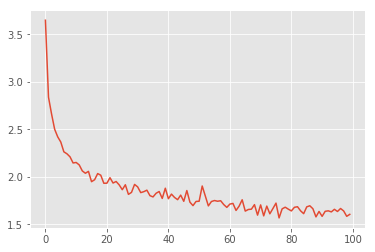

In [24]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

In [25]:
# Evaluate model from this notebook
print(evaluate(model, 'To be or not to be: ', predict_len=200, temperature=0.5))

To be or not to be: i m man that to the did bought nigga was heart all my niggas a can boy dont dont to king me comple a second the mecond i dont and dont dont dont sin no when i was hoes i want i got a to so didnt dont 


In [26]:
# Evaluate model from this notebook
print(evaluate(model, 'I miss you girl come back ', predict_len=200, temperature=0.5))

I miss you girl come back big be i and and the motherfuck the back all that the was bout i to back i dont everything i see a kendrick can the cound i can dont to that you can bitch i back all go and the and dont come i know th


In [27]:
# Evaluate model from this notebook
print(evaluate(model, "Started from the bottom", predict_len=200, temperature=0.4))

Started from the bottom the song you dont dont bout you know i was that you king thats i can controne i back a dont boy and dont new bout you dont come i can had bang i dont be and the for my can the can dont compton back i


In [28]:
# Evaluate model from this notebook
print(evaluate(model, "I'm the realest rapper alive", predict_len=200, temperature=0.4))

I'm the realest rapper alive i complets i know when you can be and the condical be and that i can a boo bout and dont dont king my song and that for the compton i sing my hole i m the come one i can back i love i can controck th


In [29]:
# Evaluate model from this notebook
print(evaluate(model, "Smoke a lot of weed", predict_len=200, temperature=0.4))

Smoke a lot of weed and the compton i dont song to the song i dont and you was and the for a compling a dont i was a see my dont come i dont complead be his dont i sing you at i cont be and propent you be what i can was


In [30]:
# Evaluate model from this notebook
print(evaluate(model, "Baby come", predict_len=200, temperature=0.4))

Baby come i was dont you aint around you a been my send me i was and you know when me be and the come me the song my nigga for i cont king you know when i dont can complication i can be dont to condo compton m
